***DATASET***


In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Data source import complete.


In [2]:
import os
import pandas as pd
import numpy as np

data_path = os.path.join(mlg_ulb_creditcardfraud_path, 'creditcard.csv')
df = pd.read_csv(data_path)

df['TransactionDensity'] = df['Amount'] / (df['Time'] + 1) # Needs to be explained

df.fillna(df.mean(numeric_only=True), inplace=True) # Fils N/A

features_to_scale_names = ['Amount', 'TransactionDensity'] # Why did I choose them?
pca_features = [f'V{i}' for i in range(1, 29)]

X = df[features_to_scale_names + pca_features].copy()
y = df['Class']

print(f"Full dataset ready for splitting. Total records: {len(df)}")
print(f"Fraud ratio: {y.mean():.4%}")

Full dataset ready for splitting. Total records: 284807
Fraud ratio: 0.1727%


***ISOLATION FOREST***


In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scaling the dataset
scaler = StandardScaler()
scaler.fit(X_train[features_to_scale_names])
X_train[features_to_scale_names] = scaler.transform(X_train[features_to_scale_names])
X_test[features_to_scale_names] = scaler.transform(X_test[features_to_scale_names])

# Isolation Forest
iforest = IsolationForest(contamination=0.01, random_state=42) # contamination='auto' leads to 3.83% outliers
X_train['isOutlier'] = iforest.fit_predict(X_train)
X_test['isOutlier'] = iforest.predict(X_test)

print("Total Anomaly Counts:")
print(X_train['isOutlier'].value_counts())

Total Anomaly Counts:
isOutlier
 1    197370
-1      1994
Name: count, dtype: int64


***UNDERSAMPLING***


In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f"Training set size (Balanced): {len(X_train_rus)}")
print(f"Test set size (Real World): {len(X_test)}")
print(f"Fraud Percentage in training data (RUS): {y_train_rus.mean():.4%}")

Training set size (Balanced): 688
Test set size (Real World): 85443
Fraud Percentage in training data (RUS): 50.0000%


***SMOTE***

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the target size for the majority class
target_size = 10000

# Undersample 'Normal' class to 10,000
rus = RandomUnderSampler(sampling_strategy={0: target_size}, random_state=42)
X_temp, y_temp = rus.fit_resample(X_train, y_train)

# SMOTE 'Fraud' class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_temp, y_temp)

print(f"Original Training Fraud Count: {y_train.value_counts()[1]}")
print(f"New Training Set Size: {len(X_train_smote)}")
print(f"New Fraud Count: {sum(y_train_smote == 1)}")
print(f"New Normal Count: {sum(y_train_smote == 0)}")
print(f"Fraud Percentage in training data: {y_train_smote.mean():.4%}")

Original Training Fraud Count: 344
New Training Set Size: 20000
New Fraud Count: 10000
New Normal Count: 10000
Fraud Percentage in training data: 50.0000%


***BALANCED RANDOM FOREST***

In [6]:
#

In [7]:
import time
from sklearn.metrics import recall_score, average_precision_score
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

# List to store results for graphing later
performance_data = []

print(f"{'Model':<25} | {'Recall':<8} | {'AUPRC':<8} | {'Train(s)':<8} | {'Inf(ms)':<8}")
print("-" * 70)

def record_performance(name, model, X_train, y_train, X_test, y_test):
    # Measure Training Time
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    # Measure Inference Time & Get Predictions
    start_inf = time.time()
    y_pred = model.predict(X_test)

    # Get scores for AUPRC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    inf_time = (time.time() - start_inf)
    inf_time_ms = (inf_time / len(X_test)) * 1000

    # Calculate Metrics
    rec = recall_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_scores)

    # Print results
    print(f"{name:<25} | {rec:.4f}   | {auprc:.4f}   | {train_time:.3f}    | {inf_time_ms:.4f}")

    # Store for graphing
    return {
        "Model": name,
        "Recall": rec,
        "AUPRC": auprc,
        "Train Time (s)": train_time,
        "Inference Time (ms)": inf_time_ms
    }

# Define the models in a list
models = [
    ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("Linear SVC", LinearSVC(C=1, random_state=42, dual=False))
]

# Run for Undersampling
print("RESULTS RUS")
for name, model in models:
    res = record_performance(f"{name}", model, X_train_rus, y_train_rus, X_test, y_test)
    performance_data.append(res)

print("-" * 70)

# Run for SMOTE
print("RESULTS SMOTE")
for name, model in models:
    res = record_performance(f"{name}", model, X_train_smote, y_train_smote, X_test, y_test)
    performance_data.append(res)

Model                     | Recall   | AUPRC    | Train(s) | Inf(ms) 
----------------------------------------------------------------------
RESULTS RUS
Logistic Regression       | 0.8716   | 0.6296   | 0.028    | 0.0009
Decision Tree             | 0.8851   | 0.0120   | 0.050    | 0.0008
Random Forest             | 0.8581   | 0.6962   | 0.571    | 0.0095
Gradient Boosting         | 0.9054   | 0.5392   | 1.239    | 0.0032
Linear SVC                | 0.8784   | 0.6638   | 0.007    | 0.0002
----------------------------------------------------------------------
RESULTS SMOTE
Logistic Regression       | 0.8716   | 0.7149   | 0.263    | 0.0003
Decision Tree             | 0.7973   | 0.0592   | 0.907    | 0.0004
Random Forest             | 0.8378   | 0.7007   | 11.518    | 0.0158
Gradient Boosting         | 0.8716   | 0.7032   | 38.891    | 0.0040
Linear SVC                | 0.8716   | 0.7131   | 0.142    | 0.0002


In [8]:
import time
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import recall_score, average_precision_score

# Define Model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Measure Training Time
start_train = time.time()
nn_model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
train_time_nn = time.time() - start_train

# Measure Inference Time & Get Predictions
start_inf = time.time()
y_probs_nn = nn_model.predict(X_test, verbose=0).flatten()
y_pred_nn_binary = (y_probs_nn > 0.5).astype('int32')
inf_time_nn = time.time() - start_inf
inf_time_ms_nn = (inf_time_nn / len(X_test)) * 1000

# Calculate Metrics
rec_nn = recall_score(y_test, y_pred_nn_binary)
auprc_nn = average_precision_score(y_test, y_probs_nn)

# Print results
print(f"{'Neural Network':<25} | {rec_nn:.4f}   | {auprc_nn:.4f}   | {train_time_nn:.3f}    | {inf_time_ms_nn:.4f}")

# Store in the same list as your other models
performance_data.append({
    "Model": "Neural Network",
    "Recall": rec_nn,
    "AUPRC": auprc_nn,
    "Train Time (s)": train_time_nn,
    "Inference Time (ms)": inf_time_ms_nn
})

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network            | 0.7905   | 0.8180   | 37.500    | 0.0473


In [9]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 15]}

# print("GridSearchCV")
# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     cv=5,
#     scoring='recall',
#     n_jobs=-1
# )
# grid_search.fit(X_train, y_train)

# print("Grid Search Complete.")
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best Cross-Validation Recall Score:", f"{grid_search.best_score_:.4f}")

# best_rf_model = grid_search.best_estimator_
# y_pred_best_rf = best_rf_model.predict(X_test)
# print("Test Set Recall Score (using Best Model):", f"{recall_score(y_test, y_pred_best_rf):.4f}")

/tmp/ipython-input-2380838180.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x='Model', y='Train Time (s)', ax=ax2, palette='magma')


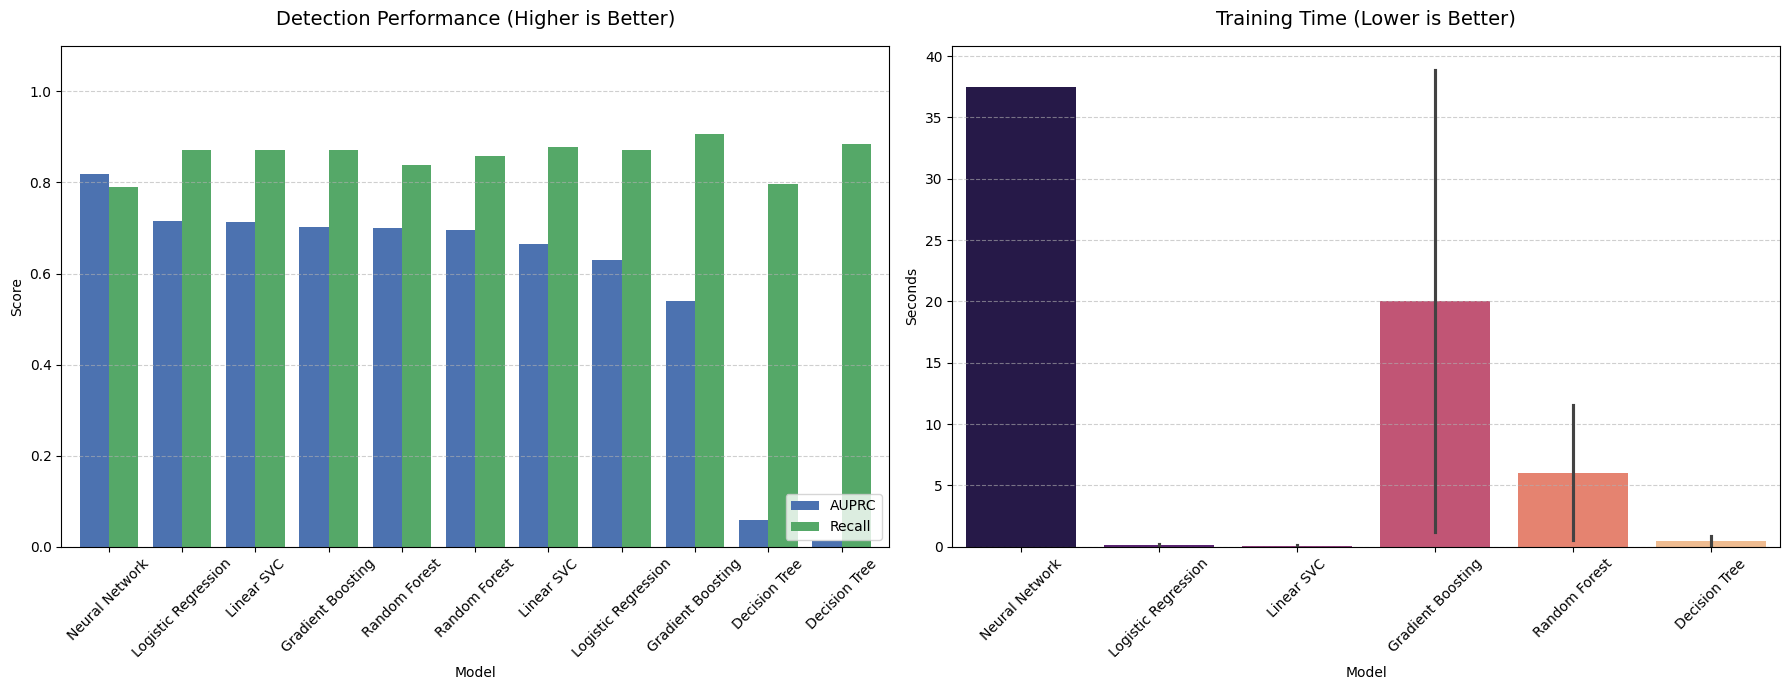

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the collected data into a DataFrame
df_results = pd.DataFrame(performance_data).sort_values(by='AUPRC', ascending=False)

# Create the Visualization with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Performance Metrics (AUPRC and Recall)
df_results.plot(x='Model', y=['AUPRC', 'Recall'], kind='bar', ax=ax1, width=0.8, color=['#4C72B0', '#55A868'])
ax1.set_title('Detection Performance (Higher is Better)', fontsize=14, pad=15)
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1.1)
ax1.legend(loc='lower right')
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.tick_params(axis='x', labelrotation=45)

# Efficiency (Training Time)
sns.barplot(data=df_results, x='Model', y='Train Time (s)', ax=ax2, palette='magma')
ax2.set_title('Training Time (Lower is Better)', fontsize=14, pad=15)
ax2.set_ylabel('Seconds')
ax2.grid(axis='y', linestyle='--', alpha=0.6)
ax2.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()